# Catastrophic Forgetting In Offline Learning

## Introduction

The phenomenon of catastrophic forgetting, or catastrophic interference, was first observed by McCloskey and Cohen (1989). It is especially salient in online learning, where training data is fed sequentially to a machine learning model for training. Of course, the phenomenon of catastrophic forgetting is also visible in offline learning. In the next experiment, we use a LeNet5 built with PyTorch to simulate this behavior and see just how catastrophic this forgetting phenomenon can be.

In [58]:
import torch
import tensorflow as tf
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [2]:
class LeNet(nn.Module):
    
    def __init__(self):
        super(LeNet, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5),
            nn.ReLU(inplace=True),
        )
        
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, img):
        X = self.convnet(img)
        X = torch.flatten(X, start_dim=1)
        X = self.fc1(X)
        X = nn.functional.relu(X)
        X = self.fc2(X)
        return X

The neural network will still train on a one hot vector of 10 classes (0 - 9), but we are going to not let it see the number 9 ever during initial training. Thus in PyTorch, we will have to create our custom dataset from MNIST with the filter.

In [3]:
class IncompleteMNIST(Dataset):
    """ Class for incomplete MNIST """
    
    def __init__(self, holdout=True, exclude=9, train=True):
        """
        :param holdout: mode of instantiation of this dataset. If holdout=True,
            data of a certain label will be excluded from training. If holdout=False,
            only the excluded data will be trained.
        :param exclude: label of data to be excluded during holdout.
        :param train: Set training or testing mode.
        """
        if train:
            (imgs, labels), _ = tf.keras.datasets.mnist.load_data()
        else:
            _, (imgs, labels) = tf.keras.datasets.mnist.load_data()
            
        if holdout:
            self.imgs = imgs[labels != exclude]
            self.labels = labels[labels != exclude]
        else:
            self.imgs = imgs[labels == exclude]
            self.labels = labels[labels == exclude]
        
        # Padding because LeNet5 requires 32 x 32 x 1 images as inputs
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Pad(2)
        ])
            
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        assert len(img.shape) == 2, \
            f"Image shape is {img.shape} instead of (28 x 28), \multi-image indexing is not supported."
        return self.transform(img), self.labels[idx]

In [4]:
trainset = IncompleteMNIST()
valset = IncompleteMNIST(train=False)
img, label = trainset[0]
print(f"Image size: {img.shape}")
print(f"label: {label}")
print(f"{len(trainset)} training data")
print(f"{len(valset)} validation data")

Image size: torch.Size([1, 32, 32])
label: 5
54051 training data
8991 validation data


Now, we shall perform training on the data that was held out. First, let's set the training hyperparameters

In [5]:
# Setup training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_loader = torch.utils.data.DataLoader(
                    trainset, 
                    batch_size=64, 
                    shuffle=True,
                    num_workers=2
                )

val_loader = torch.utils.data.DataLoader(
                    valset, 
                    batch_size=64, 
                    shuffle=True,
                    num_workers=2
                )

Next we build the inner training loop for one epoch.

In [6]:
def train(model, train_loader):
    running_loss = 0.0
    last_loss = 0.0
    
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        imgs, labels = data
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(imgs.to(device))
        
        # Compute loss and backpropagate error gradients
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        
        # Gradient descent
        optimizer.step()
        
        # Gather running loss
        running_loss += loss.item()
        
        # Calculate avg loss across 1000 batches
        if i % 64 == 63:
            last_loss = running_loss / 1000
            running_loss = 0.0
        
    return last_loss

We also define an accuracy function and a validation inner loop, which will be useful even for later.

In [7]:
def calculate_error(logits, labels):
    # Calculate the error rate
    predictions = torch.argmax(torch.softmax(logits, dim=1),dim=1)
    error_rate = (labels != predictions).sum() / len(labels)
    return error_rate

In [8]:
def validate(model, ValDataLoader):
    running_vloss = 0.0
    running_error = 0.0
    for i, vdata in enumerate(val_loader):
        v_inputs, v_labels = vdata
        v_outputs = model(v_inputs.to(device))
        error = calculate_error(v_outputs, v_labels.to(device))
        running_error += error
        v_loss = criterion(v_outputs, v_labels.to(device))
        running_vloss += v_loss
        
    avg_vloss = running_vloss / (i + 1)
    avg_verror = running_error / (i + 1)
    
    return (avg_vloss, avg_verror)

In [13]:
# Epoch Training
num_epochs = 20

best_verror = 1_000_000

for epoch in tqdm(range(num_epochs)):
    
    # Inner training loop
    avg_loss = train(model, train_loader)
    
    running_vloss = 0.0
    running_error = 0.0
    for i, vdata in enumerate(val_loader):
        v_inputs, v_labels = vdata
        v_outputs = model(v_inputs.to(device))
        error = calculate_error(v_outputs, v_labels.to(device))
        running_error += error
        v_loss = criterion(v_outputs, v_labels.to(device))
        running_vloss += v_loss
        
    avg_vloss = running_vloss / (i + 1)
    avg_verror = running_error / (i + 1)
    
    if avg_verror < best_verror:
        best_verror = avg_verror
        torch.save(model.state_dict(), "best-model.pth")
        
    tqdm.write(
        f"Train loss: {avg_loss:.3f}, \
        Validation loss: {avg_vloss:.3f}, \
        Validation error: {avg_verror:.3f}")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.018,         Validation loss: 0.252,         Validation error: 0.076


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.015,         Validation loss: 0.200,         Validation error: 0.061


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.011,         Validation loss: 0.178,         Validation error: 0.054


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.009,         Validation loss: 0.154,         Validation error: 0.048


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.009,         Validation loss: 0.125,         Validation error: 0.038


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.007,         Validation loss: 0.123,         Validation error: 0.037


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.008,         Validation loss: 0.118,         Validation error: 0.035


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.007,         Validation loss: 0.099,         Validation error: 0.030


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.007,         Validation loss: 0.099,         Validation error: 0.030


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.006,         Validation loss: 0.095,         Validation error: 0.029


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.006,         Validation loss: 0.086,         Validation error: 0.025


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.005,         Validation loss: 0.085,         Validation error: 0.025


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.006,         Validation loss: 0.083,         Validation error: 0.025


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.004,         Validation loss: 0.080,         Validation error: 0.025


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.005,         Validation loss: 0.078,         Validation error: 0.024


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.004,         Validation loss: 0.069,         Validation error: 0.020


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.005,         Validation loss: 0.079,         Validation error: 0.023


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.004,         Validation loss: 0.079,         Validation error: 0.024


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.004,         Validation loss: 0.071,         Validation error: 0.022


  0%|          | 0/845 [00:00<?, ?it/s]

Train loss: 0.004,         Validation loss: 0.063,         Validation error: 0.019


We can see that the validation error drops quite significantly with each epoch. Now, assume that we realized the existance of "9", what should we do? One may think that we can just start feeding the model with the new samples, and ask it to learn on the "9", achieving some form of incremental improvement effect. Let's try it out.

In [12]:
# Instantiate a new dataset with only the samples of 9 in it
# We will reuse validation set from before to show catastrophic forgetting on the old task.
# We set batch size to 1 to fully see the effects of each sample on the model
model = LeNet()
model.load_state_dict(torch.load("best-model.pth"))
newtrainset = IncompleteMNIST(holdout=False)
print(f"{len(newtrainset)} training data")
newtrainloader = torch.utils.data.DataLoader(
                    newtrainset, 
                    batch_size=1, 
                    shuffle=True,
                    num_workers=1
                )

5949 training data


In [15]:
# For a sanity check, let's make sure this model can indeed classify 0 - 8
model = model.to(device)

vloss, verror = validate(model, val_loader)
    
print(f"Validation loss: {vloss: .3f}")
print(f"Validation error: {verror: .3f}")

Validation loss:  0.063
Validation error:  0.019


In [12]:
# Reinitialize optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
# Next we train the model on one data point
losses = []
errors = []

for i, data in enumerate(newtrainloader):
    imgs, labels = data

    optimizer.zero_grad()

    # Forward pass
    outputs = model(imgs.to(device))

    # Compute loss and backpropagate error gradients
    loss = criterion(outputs, labels.to(device))
    loss.backward()

    # Gradient descent
    optimizer.step()

    vloss, verror = validate(model, val_loader)
    
    print(f"Loss: {vloss.item()}, Error: {verror.item()}")
    
    # For plotting
    losses.append(vloss.item())
    errors.append(verror.item())
    
    if verror > 1 - 1e-3:
        print("Error approximate to 1. Terminating...")
        break


Loss: 0.07043291628360748, Error: 0.022059453651309013
Loss: 0.1653931587934494, Error: 0.052111927419900894
Loss: 0.5302544236183167, Error: 0.18099762499332428
Loss: 1.018289566040039, Error: 0.3221302330493927
Loss: 1.696558952331543, Error: 0.4251136779785156
Loss: 2.256622076034546, Error: 0.5017015337944031
Loss: 3.026606798171997, Error: 0.6386767625808716
Loss: 4.104151248931885, Error: 0.7019382119178772
Loss: 5.45741081237793, Error: 0.7821078896522522
Loss: 7.039127349853516, Error: 0.8422807455062866
Loss: 8.854499816894531, Error: 0.9208633303642273
Loss: 10.747515678405762, Error: 0.9810433387756348
Loss: 12.626523971557617, Error: 0.9978944659233093
Loss: 14.398246765136719, Error: 0.9993350505828857
Error approximate to 1. Terminating...


Text(0.5, 1.0, 'Error Rate')

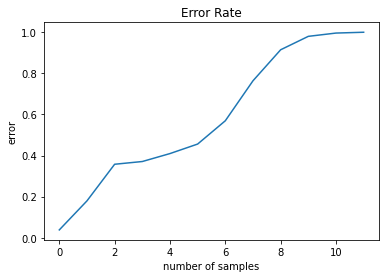

In [36]:
from matplotlib import pyplot as plt

plt.plot(errors)
plt.ylabel("error")
plt.xlabel("number of samples")
plt.title("Error Rate")

Text(0.5, 1.0, 'Validation Loss')

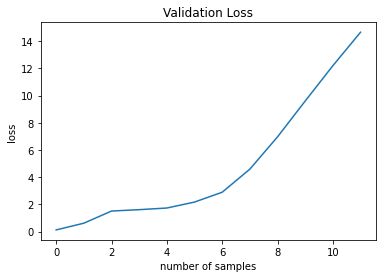

In [37]:
plt.plot(losses)

plt.ylabel("loss")
plt.xlabel("number of samples")
plt.title("Validation Loss")

From the above experiment, we can see that if you sequentially feed a model with data that it has not seen before and ask it to train on it with SGD, the loss and error will monotonously increase with each new datapoint being trained on. This is much like the online case where the model seems to disregard what it has previously learned and overfit on the latest new data. Next, we should look into some possible solutions (albeit naive ones).

## Batch Replay

One insight about continual learning is that humans don't just learn from new data. We compare and contrast with past memory of what we already know. We can try to replicate this by assuming a perfect memory (or storage) of past data, and we stochastically sample each batch to mix with the new incoming data. In the next part, we will implement such as batching mechanism.

In [53]:
# Reload a new trained model
model = LeNet()
model.load_state_dict(torch.load("best-model.pth"))
model = model.to(device)
vloss, verror = validate(model, val_loader)
print(f"Validation loss: {vloss: .3f}")
print(f"Validation error: {verror: .3f}")

Validation loss:  0.063
Validation error:  0.019


In [54]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# We need a new batching mechanism which mixes new data from 
# newtrainset with other samples from trainset, forming a batch.
batch_size = 64

newtrainloader = torch.utils.data.DataLoader(
                    newtrainset, 
                    batch_size=batch_size // 10, 
                    shuffle=True,
                    num_workers=2
                )
losses = []
errors = []

for i, data in tqdm(enumerate(newtrainloader), total=len(newtrainloader)):
    img1, label1 = data
    
    # Create a temporary data loader
    # with stochastic samples of 0 - 8 data
    tmploader = DataLoader(
        trainset, 
        batch_size=batch_size - batch_size // 10,
        sampler=np.random.permutation(len(trainset)),
        num_workers=2
    )
    
    for _, data2 in enumerate(tmploader):
        img2, label2 = data2
        break
        
    # Collate the batch
    imgs = torch.cat((img1, img2), dim=0)
    labels = torch.cat((label1, label2))
    
    # Shuffle the data and labels
    indices = torch.randperm(len(labels))
    imgs = imgs[indices]
    labels = labels[indices]
    
    optimizer.zero_grad()

    # Forward pass
    outputs = model(imgs.to(device))

    # Compute loss and backpropagate error gradients
    loss = criterion(outputs, labels.to(device))
    loss.backward()

    # Gradient descent
    optimizer.step()

    vloss, verror = validate(model, val_loader)
    
    # For plotting
    losses.append(vloss.item())
    errors.append(verror.item())
    

Text(0.5, 1.0, 'Validation Loss')

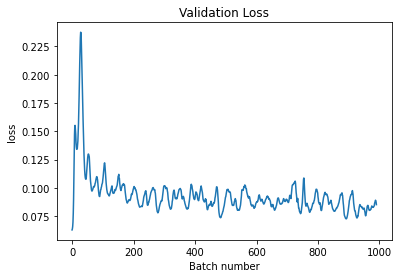

In [61]:
plt.plot(losses)
plt.ylabel("loss")
plt.xlabel("Batch number")
plt.title("Validation Loss")

Text(0.5, 1.0, 'Validation Error')

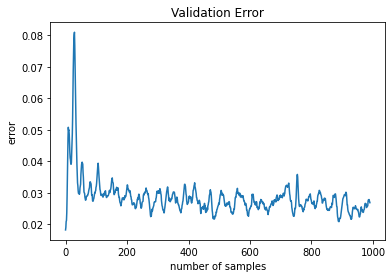

In [62]:
plt.plot(errors)
plt.ylabel("error")
plt.xlabel("number of samples")
plt.title("Validation Error")

With the batching strategy, the validation error and loss no longer monotonously increase when tested on the old validation set of samples with labels 0 - 8. We can also inspect how the model performs on samples of 9.

In [68]:
newvalset = IncompleteMNIST(holdout=False, train=False)
print(f"{len(newvalset)} training data")
newvalloader = torch.utils.data.DataLoader(
                    newvalset, 
                    batch_size=16, 
                    shuffle=True,
                    num_workers=2
                )
loss, error = validate(model, newvalloader)
print(f"Validation loss: {loss.item():.3f}")
print(f"Validation error: {error.item():.3f}")

1009 training data
Validation loss: 0.085
Validation error: 0.027


In [70]:
# This is the average for samples 0 - 8
loss, error = validate(model, val_loader)
print(f"Validation loss: {loss.item():.3f}")
print(f"Validation error: {error.item():.3f}")

Validation loss: 0.086
Validation error: 0.027


In [81]:
# Sanity check
img, label = newvalset[0]
predict = model(img.unsqueeze(0).to(device))
predicted_label = torch.argmax(torch.softmax(predict, dim=1))
print(f"Predicted label: {predicted_label}")
print(f"Actual label: {label}")

Predicted label: 9
Actual label: 9
